# Hands on session: Autoencoders (1)
This is the first of two examples, where we will use Autoencoders to reduce the dimensionality of the calcium imaging data. We will use the same dataset as in the previous exercises (PCA, Clustering methods). 

In this example, we encode the calcium data for each neuron, i.e., we represent each neuron in a lower-dimensional space, compressing the time information. 

This exercise refers to Chapter 4 "Autoencoders" of the "Dimensionality reduction in neuroscience" course (tutor: Fabrizio Musacchio, Oct 17, 2024)

## Acknowledgements:
The dataset is from the 2023's course 'data analysis techniques in neuroscience' by the Chen Institute for Neuroscience at Caltech:  

<https://github.com/cheninstitutecaltech/Caltech_DATASAI_Neuroscience_23>

and originally from the paper:

Remedios, R., Kennedy, A., Zelikowsky, M. et al. Social behaviour shapes hypothalamic neural  ensemble representations of conspecific sex. Nature 550, 388–392 (2017). <https://doi.org/10.1038/nature23885>

## Dataset
We will work with the same calcium imaging data from the previous exercise (PCA). For details, please refer to the previous exercise.

## Environment setup
For reproducibility:

```bash
conda create -n dimredcution python=3.11 mamba -y
conda activate dimredcution
mamba install ipykernel matplotlib numpy scipy scikit-learn -y
mamba install pytorch torchvision -c pytorch
```

Let's start, as usual, by importing the necessary libraries:

In [1]:
# %% IMPORTS
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from mpl_toolkits import mplot3d
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset

# for reproducibility, we set the random seed:
np.random.seed(42)
torch.manual_seed(42)

/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <253997FD-685F-34A9-B3D7-4AF6DAE96CDF> /Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/husker/miniforge3/envs/dimredcution/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you c

Verify the torch version and that the GPU is available:

In [2]:
# verify torch version and GPU availability:
print(f"torch backend MPS is available? {torch.backends.mps.is_available()}")
print(f"current PyTorch installation built with MPS activated? {torch.backends.mps.is_built()}")
print(f"check the torch MPS backend: {torch.device('mps')}")
print(f"test torch tensor on MPS: {torch.tensor([1,2,3], device='mps')}")

torch backend MPS is available? True
current PyTorch installation built with MPS activated? True
check the torch MPS backend: mps
test torch tensor on MPS: tensor([1, 2, 3], device='mps:0')


On macOS, you need to move your later model to the MPS device, if you want to use the Mac's GPU (Apple Silicon):


In [3]:
# device = torch.device('mps')
# model = model.to(device)

Otherwise, change this line to:

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

Define the path to the data:

In [5]:
DATA_PATH = '../data/'
DATA_FILENAME = 'hypothalamus_calcium_imaging_remedios_et_al.mat'
DATA_FILE = os.path.join(DATA_PATH, DATA_FILENAME)

RESULTSPATH = '../results/'
# check whether the results path exists, if not, create it:
if not os.path.exists(RESULTSPATH):
    os.makedirs(RESULTSPATH)

Load the data:

In [6]:
hypothalamus_data = loadmat(DATA_FILE)

# extract the N main data arrays into N separate variables:
neural_data   = hypothalamus_data['neural_data']
attack_vector = hypothalamus_data['attack_vector']
gender_vector = hypothalamus_data['sex_vector']

# we just take a short snippet of the data to speed up the computations:
N_datapoints = 10000
neural_data_short = neural_data[:, 0:N_datapoints]
print(f"The shape of the data is: {neural_data_short.shape}")

The shape of the data is: (115, 10000)


We define a custom dataset class for the neural data (this is necessary for Pytorch's DataLoader):

In [7]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        instance = self.data[idx, :]
        sample = {"data": instance}
        return sample

Pytorch works best with tensors, so we convert the numpy array to a tensor. A tensor is a container that stores data in $N$ dimensions. A matrix is a special case of a tensor that is 2D:

In [8]:
neural_data_float_tensor = torch.tensor(neural_data_short).float()

## 📝 Inspect the shape of the `neural_data_float_tensor`

In [9]:
# Your code goes here:

# SOL:
print(neural_data_float_tensor.shape)


torch.Size([115, 10000])


Now we apply the `CustomDataset` class to our neural data tensor `neural_data_float_tensor`:

In [10]:
neural_dataset_tensor = CustomDataset(neural_data_float_tensor)

## 📝 Inspect `neural_dataset_tensor` created by the `CustomDataset` class
1. Inspect the `.__len__()` method.
2. Inspect the `.__getitem__(0)` method.
3. Inspect the `.__getitem__(0).keys()` method.
4. Inspect the `.__getitem__(0)['data'].shape` method.
5. Also inspect the above methods for another index.

In [11]:
# Your code goes here:

# SOL:
print(f"neural_dataset_tensor: {neural_dataset_tensor}")
print(f"neural_dataset_tensor's length: {neural_dataset_tensor.__len__()}")
print(f"neural_dataset_tensor's __getitem__(0): {neural_dataset_tensor.__getitem__(0)}")
print(f"neural_dataset_tensor's __getitem__(0).keys(): {neural_dataset_tensor.__getitem__(0).keys()}")
print(f"neural_dataset_tensor's __getitem__(0)['data'].shape: {neural_dataset_tensor.__getitem__(0)['data'].shape}")

print(neural_dataset_tensor.__getitem__(114).keys())
print(neural_dataset_tensor.__getitem__(114)['data'].shape)



neural_dataset_tensor: <__main__.CustomDataset object at 0x303b96550>
neural_dataset_tensor's length: 115
neural_dataset_tensor's __getitem__(0): {'data': tensor([-0.8854, -0.8057, -0.7376,  ...,  1.8616,  1.8404,  1.8145])}
neural_dataset_tensor's __getitem__(0).keys(): dict_keys(['data'])
neural_dataset_tensor's __getitem__(0)['data'].shape: torch.Size([10000])
dict_keys(['data'])
torch.Size([10000])


Now we are going to break our data into a train (90% of the data) and test (10% of the data) split:

In [12]:
train_size = int(np.floor(0.9 * len(neural_dataset_tensor)))
test_size = len(neural_dataset_tensor) - train_size

print(train_size, test_size)
# train_size, test_size is (103, 12), ie., 90% (=103/115) and 10% (=12/115) neurons of the full data set

103 12


Now using the `torch.utils.data.random_split()` function we split the data into a  train set and a test set; for this, we could use this command:

```python
train_dataset, test_dataset = torch.utils.data.random_split(neural_dataset_tensor, [train_size, test_size])
```

However, we want to keep track of the original neuron IDs, so we will do it manually:

In [13]:
dataset_size = len(neural_dataset_tensor)
indices = list(range(dataset_size))
#train_dataset, test_dataset = torch.utils.data.random_split(neural_dataset_tensor, [train_size, test_size])

# randomly split the indices:
train_indices, test_indices = torch.utils.data.random_split(indices, [train_size, test_size])

# create subsets using the indices:
train_dataset = Subset(neural_dataset_tensor, train_indices)
test_dataset  = Subset(neural_dataset_tensor, test_indices)

# To re-identify the original ID of each neuron in the train_dataset, we store the original indices:
original_train_ids = train_indices.indices

## 📝 Create the data loaders
Using the `torch.utils.data.DataLoader()`, make a train data loader and a test data loader. Make sure to use the dataset, batch_size, and shuffle parameters when you call the function. If you are not familiar with the DataLoader, please check the Pytorch documentation. For simplicity, set the batch size to be larger than all the data you have. This is okay for our small dataset, but in practice, you would want to set the batch size to be a smaller number.

In [14]:
# Your code goes here:

# train_loader = torch.utils.data.DataLoader(...)
# test_loader  = torch.utils.data.DataLoader(...)


# SOL:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=150, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=150, shuffle=True)

## 📝 Now, define the Autoencoder model
1. Create a class `Autoencoder` that inherits from `torch.nn.Module`. Create a linear `encoder` with the following layers:
   - A linear layer with 10000 input features and 5000 output features.
   - A ReLU activation function.
   - A linear layer with 5000 input features and 2500 output features.
   - A ReLU activation function.
   - A linear layer with 2500 input features and 625 output features.
   - A ReLU activation function.
   - A linear layer with 625 input features and 156 output features.
   - A ReLU activation function.
   - A linear layer with 156 input features and 39 output features.
   - A ReLU activation function.
   - A linear layer with 39 input features and 3 output features.
2. Create an according linear `decoder`.
3. Define a `forward` method that takes an input x and returns the embedding and the reconstruction of the input data.

In [15]:
# Your code goes here:
# class Autoencoder(...):
#     def __init__(self):
#         super().__init__()
#        
#         self.encoder = torch.nn.Sequential(
#             ...
#         )
          
#         self.decoder = torch.nn.Sequential(
#             ...
#         )
  
#     def forward(self, x):
#         ...
#         return embedding, reconstruction


# SOL:

class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Implementing a linear encoder.
        # Each layer is composed of a linear layer followed by a Relu activation function.
        # The last layer is just a linear layer!
        # We take a data point from a dimension of 10000 and compress it to a dimension of 3.
        dropout = 0.6
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(10000, 5000),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),  # Dropout layer
            torch.nn.Linear(5000, 2500),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),  # Dropout layer
            torch.nn.Linear(2500, 625),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),  # Dropout layer
            torch.nn.Linear(625, 156),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),  # Dropout layer
            torch.nn.Linear(156, 39),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),  # Dropout layer
            torch.nn.Linear(39, 3)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 39),
            torch.nn.ReLU(),
            torch.nn.Linear(39, 156),
            torch.nn.ReLU(),
            torch.nn.Linear(156, 625),
            torch.nn.ReLU(),
            torch.nn.Linear(625, 2500),
            torch.nn.ReLU(),
            torch.nn.Linear(2500, 5000),
            torch.nn.ReLU(),
            torch.nn.Linear(5000, 10000)
        )
  
    def forward(self, x):
        embedding = self.encoder(x)
        reconstruction = self.decoder(embedding)
        return embedding, reconstruction


## 📝  Train the autoencoder

Prepare and create a training loop to train the autoencoder on the training data:
1. Train the autoencoder for 250 epochs.
2. Keep track of the training and validation losses.
3. As loss function, use the Mean Squared Error (MSE) loss (`torch.nn.MSELoss()`).
4. Use the Adam optimizer (`torch.optim.Adam(...)`) with an initial learning rate of 1e-2, a `weight_decay` of 1e-8 and a `step_size` of 1.
5. Follow further instructions below to complete the code.

In [16]:
# Your code goes here:

# set training parameters:
# epochs =

# prepare lists to store the outputs and losses:

# model initialization (just uncomment the line below):
# model = Autoencoder()

# on macOS, move the model to the MPS device:
# device = torch.device('mps')
# model = model.to(device)

# otherwise, move the model to the GPU if available:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)


# using Mean-Squared-Error MSE Loss function:
# loss_function = ...

# using an Adam Optimizer:
# learning_rate = ...
# optimizer = torch.optim.Adam(...)

# learning rate scheduler (just uncomment the line below):
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=0.98)


# define the training loop:
#for epoch in range(epochs):
#    # training on train set:
#    model.train()
#    
#    # loop through your training data;
#    for batch_idx, batch in enumerate(train_loader):

        # STEP 1: pull out the data from your batch
        # batch_data = ...
        
        # STEP 2: get the reconstructed data from the Autoencoder Output
        # ...

        # STEP 3: calculate the loss function between the reconstruction and original data
        # loss = ...

        # set gradients to zero (just uncomment the line below):
        #optimizer.zero_grad()
        
        # the gradient is computed and stored (just uncomment the line below):
        #loss.backward()
        
        # perform the parameter update (just uncomment the line below):
        #optimizer.step()

        # storing the losses in a list for plotting
        # ...
       
    # put model into evaluation mode (just uncomment the line below):
    # model.eval()
    
    # loop through your testing/validation data:
    #for validation_batch_idx, validation_batch in enumerate(test_loader):
    
        # STEP_4: pull out the data from your validation batch
        # validation_batch_data = ...
        
        # STEP 5: get the reconstructed data from the Autoencoder Output
        # ...
        
        # STEP 6: calculate the loss function between the reconstrucion and original data
        # val_loss = ...
        
        # STEP 7: append the validation losses to the validation loss list
        #... 
    
    # STEP 8: append the outputs to both the validation and train outputs lists in the form of:
    # (epochs, original data, reconstruction, embedding). Don't forget to transform your tensors into numpy arrays!!!
    # validation_outputs.append(...)
    # outputs.append(...)
    
    # uncomment the line below to print the epoch number and the losses:
    # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {losses[-1]:.6f}, Val Loss: {validation_losses[-1]:.6f}')

#print(len(outputs))

#print(f"epoch number: {outputs[-1][0]}") # epoch number
#print(f"original data: {outputs[-1][-1].shape}") # original data
#print(f"reconstructed data{outputs[-1][-2].shape}") # reconstructed data


# SOL:
# set training parameters:
epochs = 249
outputs = []
losses = []
validation_outputs = []
validation_losses = []

# model initialization:
model = Autoencoder()
# On macOS, move the model to the MPS device:
device = torch.device('mps')
model = model.to(device)

# otherwise, move the model to the GPU if available:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# using Mean-Squared-Error MSE Loss function:
loss_function = torch.nn.MSELoss()
# using an Adam Optimizer:
learning_rate = 1e-4  # 1e-2 1e-3  1e-4 with dropout 0.6 worked best 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
# learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=0.98)

# training loop
for epoch in range(epochs):
    # training on train set
    model.train()
    
    # Loop through your training data
    for batch_idx, batch in enumerate(train_loader):
        # STEP 1: pull out the data from your batch
        batch_data = batch['data'].to(device)
        
        # STEP 2: get the reconstructed data from the Autoencoder Output
        embedding, reconstructed = model(batch_data)

        # STEP 3: calculate the loss function between the reconstruction and original data
        loss = loss_function(reconstructed, batch_data)

        # set gradients to zero
        optimizer.zero_grad()
        # the gradient is computed and stored
        loss.backward()
        # perform the parameter update
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(float(loss.detach()))
       
    # put model into evaluation mode
    model.eval()
    # loop through your testing/validation data
    for validation_batch_idx, validation_batch in enumerate(test_loader):
        # STEP_4: pull out the data from your validation batch
        validation_batch_data = validation_batch['data'].to(device)
        
        # STEP 5: get the reconstructed data from the Autoencoder Output
        validation_embedding, reconstructed_validation = model(validation_batch_data)
        
        # STEP 6: calculate the loss function between the reconstrucion and original data
        val_loss = loss_function(reconstructed_validation, validation_batch_data)
        
        # STEP 7: append the validation losses to the validation loss list
        validation_losses.append(float(val_loss.detach()))
    
    # STEP 8: append the outputs to both the validation and train outputs lists in the form of:
    # (epochs, original data, reconstruction). Don't forget to transform your tensors into numpy arrays!!!
    validation_outputs.append((epoch, validation_batch_data.detach().cpu().numpy(), reconstructed_validation.detach().cpu().numpy(), validation_embedding.detach().cpu().numpy()))
    outputs.append((epoch, batch_data.detach().cpu().numpy(), reconstructed.detach().cpu().numpy(), embedding.detach().cpu().numpy()))
    
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {losses[-1]:.6f}, Val Loss: {validation_losses[-1]:.6f}')

print(len(outputs))

print(f"epoch number: {outputs[-1][0]}") # epoch number
print(f"original data: {outputs[-1][-1].shape}") # original data
print(f"reconstructed data{outputs[-1][-2].shape}") # reconstructed data


Epoch 1/249, Train Loss: 3.482791, Val Loss: 4.568964
Epoch 2/249, Train Loss: 3.478561, Val Loss: 4.563412
Epoch 3/249, Train Loss: 3.473860, Val Loss: 4.556494
Epoch 4/249, Train Loss: 3.467858, Val Loss: 4.547578
Epoch 5/249, Train Loss: 3.459662, Val Loss: 4.536140
Epoch 6/249, Train Loss: 3.449978, Val Loss: 4.521388
Epoch 7/249, Train Loss: 3.436096, Val Loss: 4.502120
Epoch 8/249, Train Loss: 3.419100, Val Loss: 4.477138
Epoch 9/249, Train Loss: 3.401265, Val Loss: 4.444276
Epoch 10/249, Train Loss: 3.367422, Val Loss: 4.400801
Epoch 11/249, Train Loss: 3.343233, Val Loss: 4.340501
Epoch 12/249, Train Loss: 3.282222, Val Loss: 4.253648
Epoch 13/249, Train Loss: 3.252229, Val Loss: 4.135318
Epoch 14/249, Train Loss: 3.196423, Val Loss: 3.985268
Epoch 15/249, Train Loss: 3.138557, Val Loss: 3.834396
Epoch 16/249, Train Loss: 3.091336, Val Loss: 3.681225
Epoch 17/249, Train Loss: 3.099454, Val Loss: 3.536817
Epoch 18/249, Train Loss: 3.077010, Val Loss: 3.435255
Epoch 19/249, Train

## 📝 Assess the loss curves
1. Plot the training and validation loss curves (i.e., your previously stored losses).
2. What do you observe?

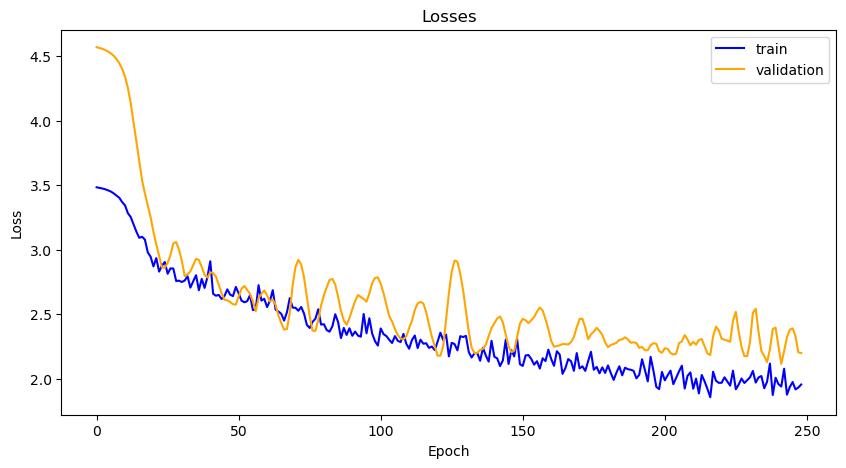

241


In [17]:
# Your code goes here:


# SOL:
fig = plt.figure(figsize=(10, 5))
plt.plot(losses, color='blue', label='train')
plt.plot(validation_losses, color='orange', label='validation')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(np.argmin(validation_losses))
# The model is trained properly around this epoch#. Any number of epoch# below is 
# underfitting, any epoch# of epochs above is overfitting.

In case you are unsatisfied with the results, you can try to improve the model by 

* changing the architecture: add Dropout layers (`torch.nn.Dropout()`) with a dropout rate of 0.5 to your encoder.
* changing the learning rate; try 1e-3 or 1e-4.

## 📝 For a sample neuron, plot the original and reconstructed data for the last epoch

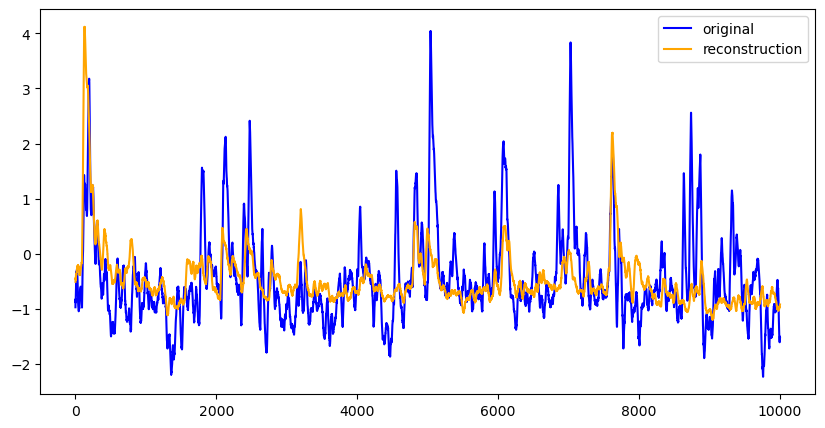

In [18]:
# Your code goes here:

# SOL:
epoch_idx = -1
neuron_idx = 10
fig = plt.figure(figsize=(10, 5))
plt.plot(outputs[epoch_idx][1][neuron_idx, :], color='blue')
plt.plot(outputs[epoch_idx][2][neuron_idx, :], color='orange')
plt.legend(['original', 'reconstruction'])

## 📝 Compare all neurons: original vs. reconstructed
1. Plot the original data and the reconstructed data with Matplotlib's `imshow`
2. Plot the original validation data and the reconstructed validation data with Matplotlib's `imshow`

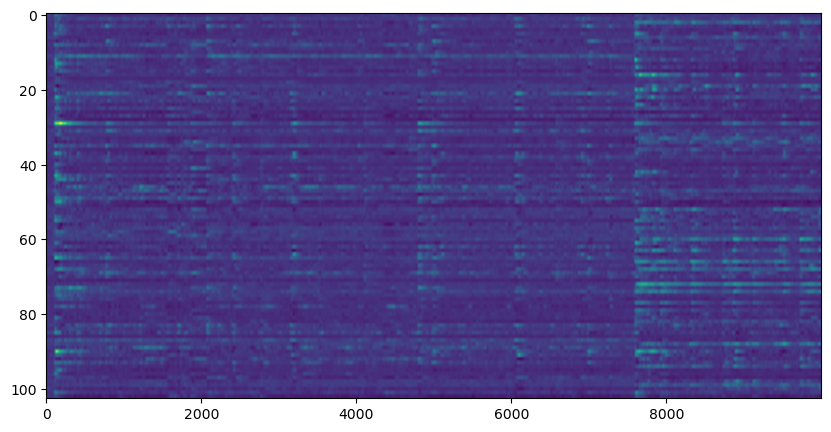

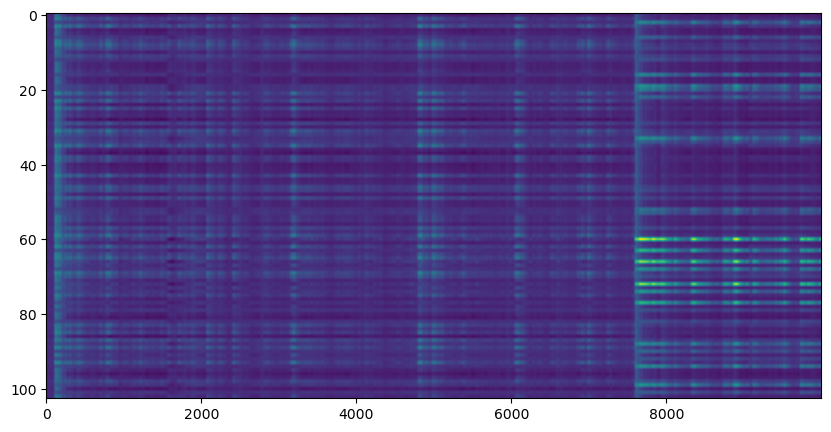

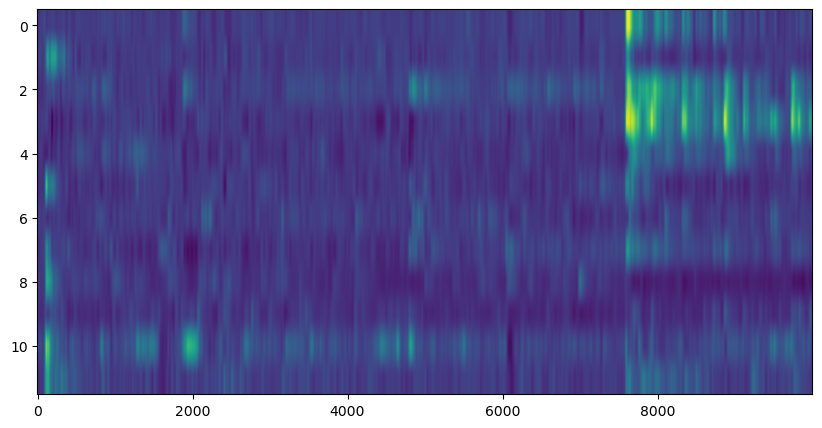

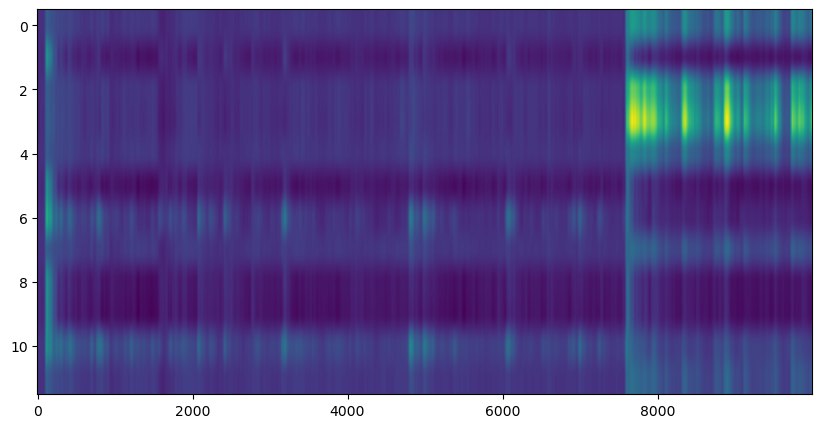

In [19]:
# Your code goes here:

# SOL:
fig = plt.figure(figsize=(10, 5))
plt.imshow(outputs[-1][1], aspect='auto') # original
plt.show()
fig = plt.figure(figsize=(10, 5))
plt.imshow(outputs[-1][2], aspect='auto') # reconstruction
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.imshow(validation_outputs[-1][1], aspect='auto') # original
plt.show()
fig = plt.figure(figsize=(10, 5))
plt.imshow(validation_outputs[-1][2], aspect='auto') # reconstruction
plt.show()


## 📝 Perform a PCA in the reconstructed data (2D comparison)
We now want to take a look at the reconstructed on PCA latent space:
1. Perform a PCA on the (original) train data and the reconstructed train data. Use three components.
2. Plot the first two PCs of each PCA (PCA of the original data and the reconstructed data) in a single 2D plot.

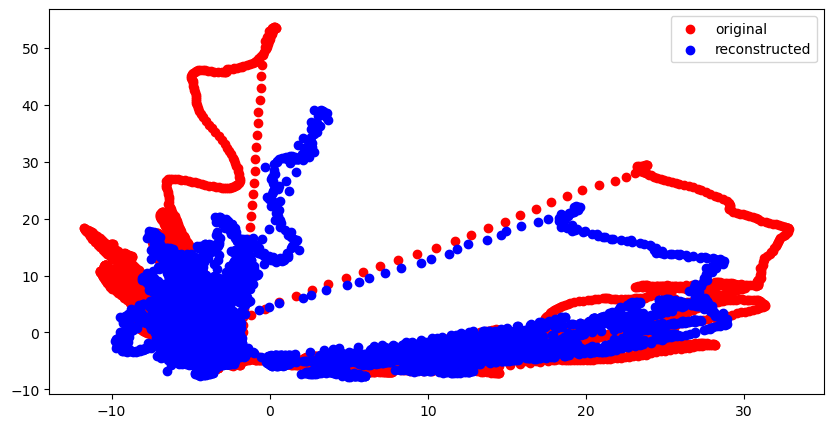

In [20]:
# Your code goes here:

# SOL:
train_original_data = outputs[-1][1]
train_reconstructed_data = outputs[-1][2]


pca_model_train_od = PCA(n_components=2)
neural_pca_train_od = pca_model_train_od.fit_transform(train_original_data.T)

pca_model_train_rd = PCA(n_components=2)
neural_pca_train_rd = pca_model_train_rd.fit_transform(train_reconstructed_data.T)

# Plot original train data and train reconstructions
fig = plt.figure(figsize=(10, 5))
plt.scatter(neural_pca_train_od[:, 0], neural_pca_train_od[:, 1], color='red', label='original')
plt.scatter(neural_pca_train_rd[:, 0], neural_pca_train_rd[:, 1], color='blue', label='reconstructed')
plt.legend()
plt.show()


## 📝 Investigate the latent space of the AE (3D)

1. Plot the AE embedding space in 3D at the first epoch (stored in `outputs[0][-1][:, 0]`, `outputs[0][-1][:, 1]`, `outputs[0][-1][:, 2]`)
2. Plot the AE embedding space in 3D at the last epoch (stored in `outputs[-1][-1][:, 0]`, `outputs[-1][-1][:, 1]`, `outputs[-1][-1][:, 2]`). What do you notice by comparing the two plots/epochs?

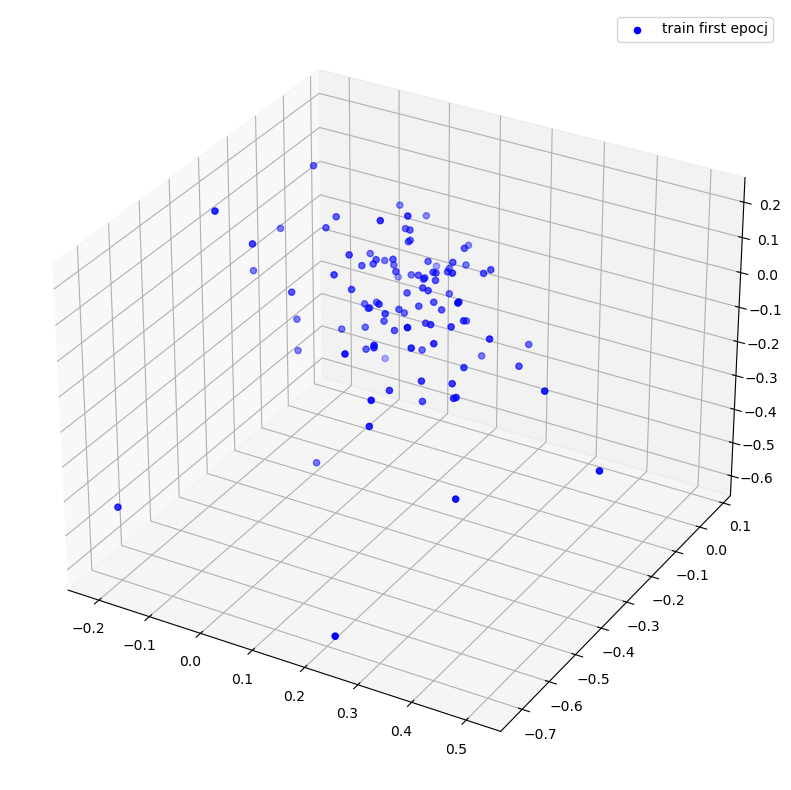

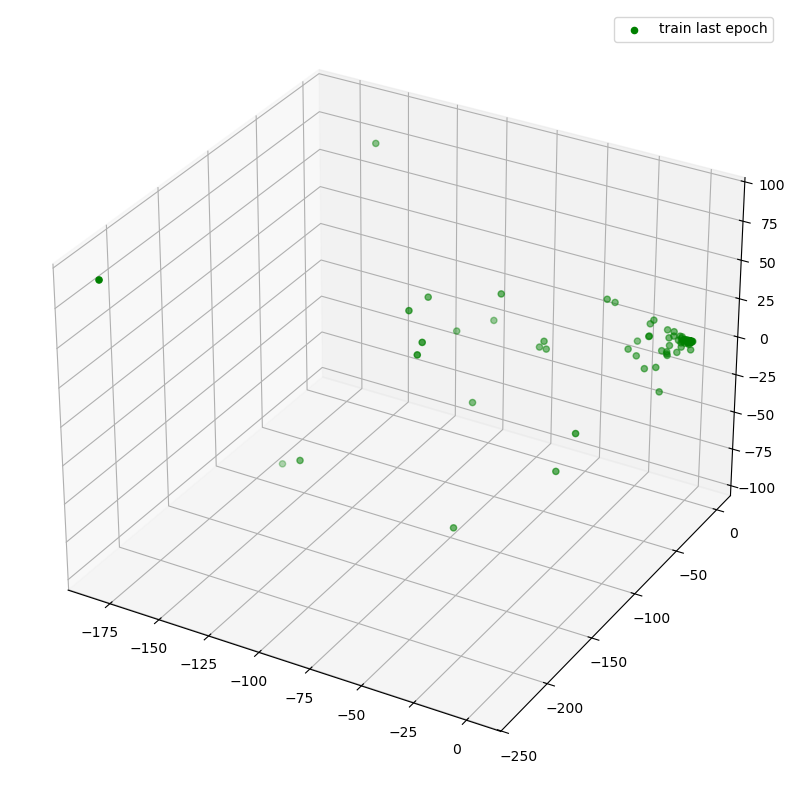

In [21]:
# Your code goes here:

# SOL:
# plot the AE embedding space in 3D at the first epoch:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(outputs[0][-1][:, 0], outputs[0][-1][:, 1], outputs[0][-1][:, 2], c='blue', label='train first epocj')
plt.legend()
plt.show()

# plot the AE embedding space in 3D at the last epoch:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(outputs[-1][-1][:, 0], outputs[-1][-1][:, 1], outputs[-1][-1][:, 2], c='green', label='train last epoch')
plt.legend()
plt.show()

## 📝 Replot the AE embedding scatter plot of the last epoch, now color-coded by the original data (`original_train_ids`)

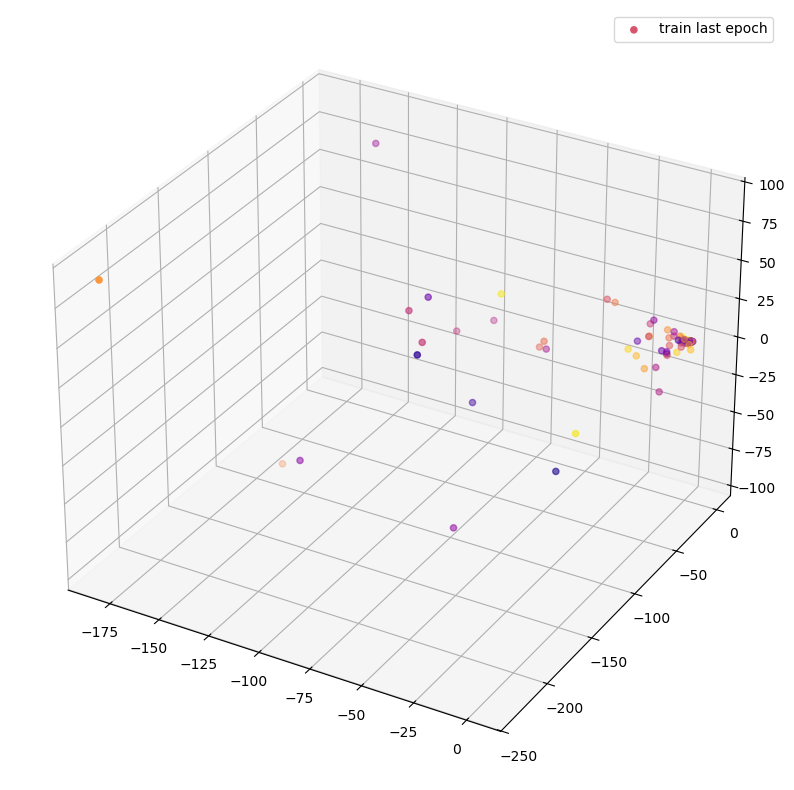

In [22]:
# Your code goes here:

# SOL:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(outputs[-1][-1][:, 0], outputs[-1][-1][:, 1], outputs[-1][-1][:, 2], 
           c=original_train_ids, cmap='plasma', label='train last epoch')
plt.legend()
plt.show()


## 📝 Cluster the AE embedded space of the last epoch using k-means (with 2 clusters) and replot the embedded space color-coded with the cluster labels

unique labels: [0 1]


/Users/husker/miniforge3/envs/dimredcution/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


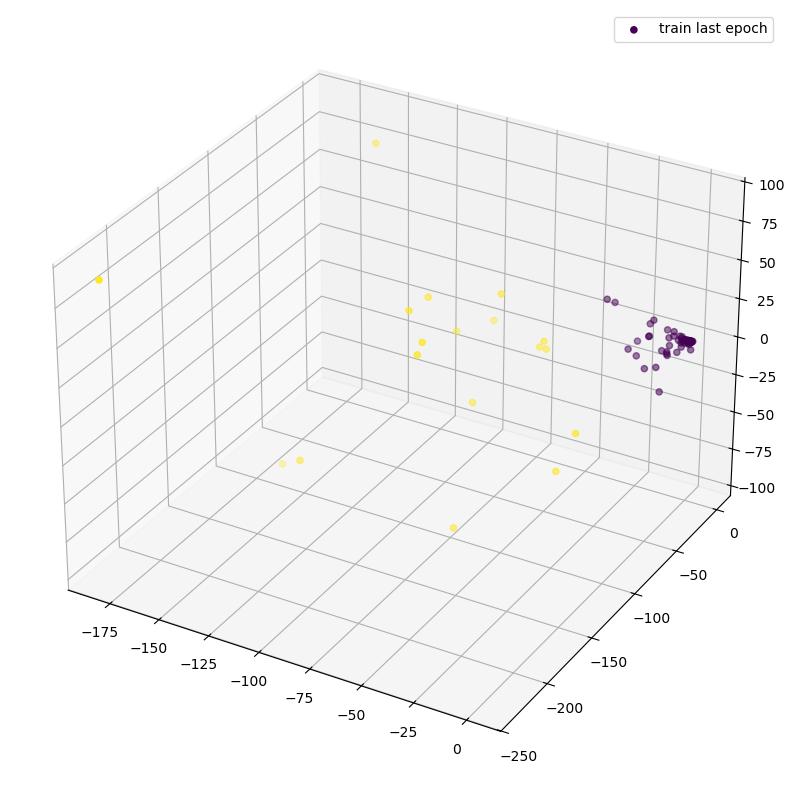

In [23]:
# Your code goes here:

# SOL:
n_clusters=2
kmeans     = KMeans(n_clusters=n_clusters, random_state=42)
embedding_last_epoch_3D = outputs[-1][-1]
embedding_last_epoch_3D_kmeans_fit = kmeans.fit(embedding_last_epoch_3D)
print(f"unique labels: {np.unique(embedding_last_epoch_3D_kmeans_fit.labels_)}")

# replot the scatter, now color-coded by the cluster-labels:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter(outputs[-1][-1][:, 0], outputs[-1][-1][:, 1], outputs[-1][-1][:, 2], 
           c=embedding_last_epoch_3D_kmeans_fit.labels_, cmap='viridis', label='train last epoch')
plt.legend()
plt.show()



## 📝 Resort the neural data
Let's check whether the clustering is consistent with the original data. To do this, sort the neural data according to the cluster labels and plot the sorted data. Compare with the original data.

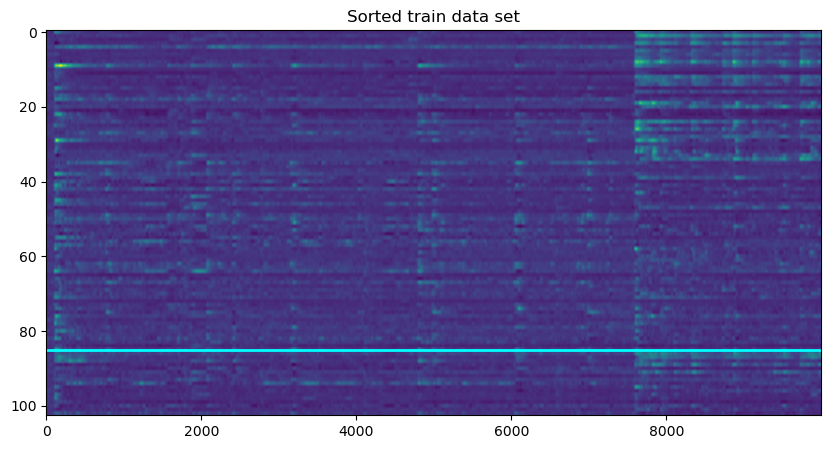

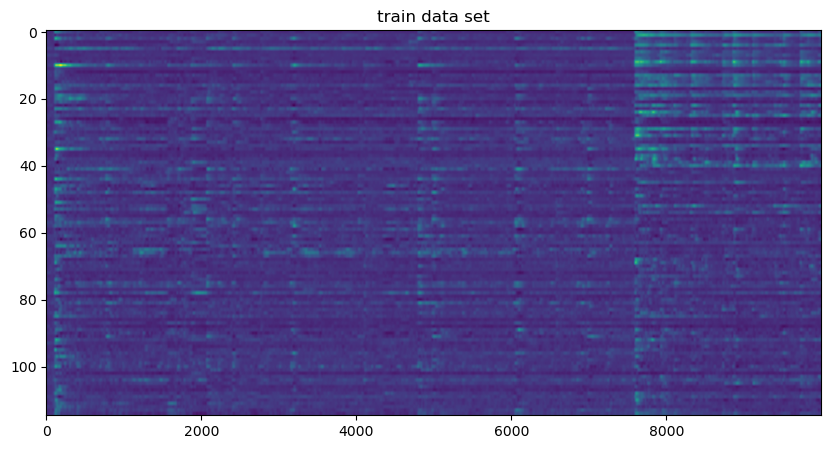

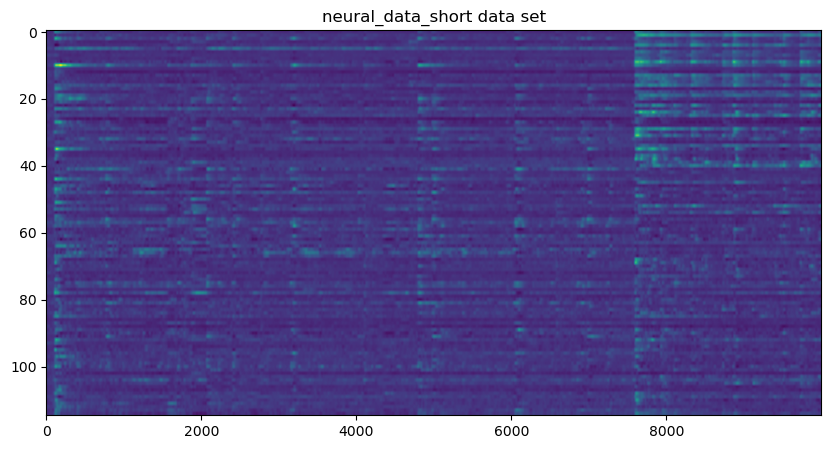

In [24]:
# Your code goes here:

# resort the train_dataset array in such a way, that all neurons of cluster 0 are first, 
# and all neurons of cluster 1 are second:

# SOL:
# resort the train_dataset array in such a way, that all neurons of cluster 0 are first, 
# and all neurons of cluster 1 are second:
original_indices_cluster_0 = np.where(embedding_last_epoch_3D_kmeans_fit.labels_ == 0)[0]
original_indices_cluster_1 = np.where(embedding_last_epoch_3D_kmeans_fit.labels_ == 1)[0]
train_dataset_numpy = train_dataset.dataset.data.numpy()
train_dataset_sorted = train_dataset_numpy[np.concatenate((original_indices_cluster_0, original_indices_cluster_1)),:]

# now plot the sorted neural data:
fig = plt.figure(figsize=(10, 5))
plt.imshow(train_dataset_sorted, aspect='auto')
# plot a horizontal line to separate the two clusters:
plt.axhline(y=len(original_indices_cluster_0), color='cyan', linewidth=2)
plt.title('Sorted train data set')
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.imshow(train_dataset_numpy, aspect='auto')
plt.title('train data set')
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.imshow(neural_data_short, aspect='auto')
plt.title('neural_data_short data set')
plt.show()

In [25]:
# SOL:
""" 
The last three plots show the sorted train data set, the original train data set, and the original neural_data_short 
data set. For the first plot, we sorted the train data set based on the cluster labels obtained from the KMeans clustering
of the AE embedding space (last epoch). It turns out, that the two clusters are well separated in the AE embedding space.
However, the sorted plot of all neurons would not suggest that the two clusters are well separated. This is due to the fact
that the AE embedding space is a non-linear transformation of the original data, which is not necessarily well represented
in the original data space.

I added the last step just to give you a glimpse of how to further evaluate the information one can gain from
the AE embedding space and make interpretations based on it.
"""

' \nThe last three plots show the sorted train data set, the original train data set, and the original neural_data_short \ndata set. For the first plot, we sorted the train data set based on the cluster labels obtained from the KMeans clustering\nof the AE embedding space (last epoch). It turns out, that the two clusters are well separated in the AE embedding space.\nHowever, the sorted plot of all neurons would not suggest that the two clusters are well separated. This is due to the fact\nthat the AE embedding space is a non-linear transformation of the original data, which is not necessarily well represented\nin the original data space.\n\nI added the last step just to give you a glimpse of how to further evaluate the information one can gain from\nthe AE embedding space and make interpretations based on it.\n'